In [1]:
import numpy as np
import pandas as pd
import scipy
import imageio
import math
import phylo as ph

from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
import warnings
sns.set(style="ticks")
plt.style.use("seaborn-whitegrid")

In [2]:
%load_ext blackcellmagic

# Preparation

All the expensive setup happens up here.

In [3]:
np.random.seed(820)
REGULAR_POKEMON = ph.vectorize_pokemon(ph.REGULAR_POKEMON_PATH)
SHINY_POKEMON = ph.vectorize_pokemon(ph.SHINY_POKEMON_PATH)

Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/regular/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing
Vectorizing pokemon from /Users/vineshkannan/Documents/GitHub/phylo/images/shiny/
Vector iteration 0
Vector iteration 100
Vector iteration 200
Vector iteration 300
Vector iteration 400
Vector iteration 500
Vector iteration 600
Done vectorizing


In [4]:
known_creatures = list(REGULAR_POKEMON) + list(SHINY_POKEMON)
np.random.shuffle(known_creatures)

In [5]:
random_vectors = [ph.generate_random() for i in range(len(known_creatures))]
expect_base_pop = known_creatures + random_vectors
len(expect_base_pop)

2596

In [6]:
n_expected = len(known_creatures)
expected_from_n_sub = 50
expected_vectors = []
for i in range(n_expected):
    ev = ph.generate_expected(expect_base_pop, expected_from_n_sub)
    ev_ob = ph.outline_body(ev)
    expected_vectors.append(ev_ob)
    if i % 100 == 0:
        print(i)
print("Done.")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Done.


In [7]:
kc_aps = [ph.active_prop(x) for x in known_creatures]
ev_aps = [ph.active_prop(x) for x in expected_vectors]
rv_aps = [ph.active_prop(x) for x in random_vectors]

# Background

Here are some kinds of vectors we are interested in.

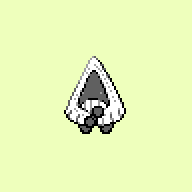

In [8]:
ph.showim(known_creatures[4], scale=2)

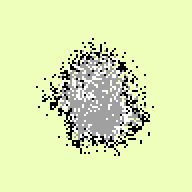

In [9]:
ph.showim(expected_vectors[4], scale=2)

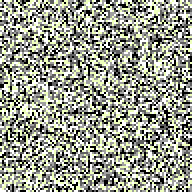

In [10]:
ph.showim(random_vectors[4], scale=2)

## Active Proportion

Active proportion is the proportion of cells that have a color quantum greater than 1.

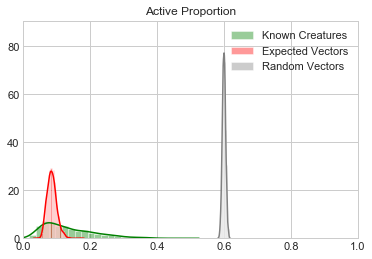

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.distplot(kc_aps, color="green", label="Known Creatures")
    sns.distplot(ev_aps, color="red", label="Expected Vectors")
    sns.distplot(rv_aps, color="gray", label="Random Vectors")
    plt.xlim(0, 1)
    plt.title("Active Proportion")
    plt.legend()

## Quantum Frequency

The frequency of each color quantum in the vector.

In [12]:
kc_qfreq = [ph.col_freq(xv) for xv in known_creatures]
ev_qfreq = [ph.col_freq(xv) for xv in expected_vectors]

In [13]:
kc_qdf = pd.DataFrame(kc_qfreq)
kc_qdf.head(3)

,0,1,2,3,4
0,0.893880,0.018446,0.044054,0.026693,0.016927
1,0.868707,0.017904,0.045681,0.049696,0.018012
2,0.755317,0.038194,0.120660,0.066840,0.018989


In [14]:
ev_qdf = pd.DataFrame(ev_qfreq)
ev_qdf.head(3)

,0,1,2,3,4
0,0.886393,0.023329,0.054579,0.0,0.035699
1,0.912652,0.020399,0.039171,0.0,0.027778
2,0.895508,0.019531,0.053168,0.0,0.031793


In [15]:
def plot_qfreq(kc_qdf, ev_qdf, qidx):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.distplot(kc_qdf[qidx], color="green", label="Known Creatures")
        sns.distplot(ev_qdf[qidx], color="red", label="Expected Vectors")    
        plt.xlim(0, 1)
        plt.title("Frequency of Q = {}".format(qidx))
        plt.legend()
        return plt

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

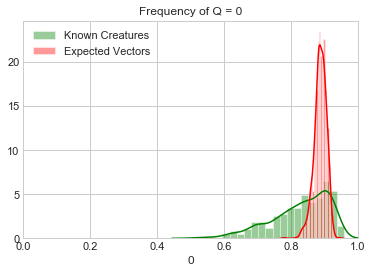

In [16]:
plot_qfreq(kc_qdf, ev_qdf, 0)

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

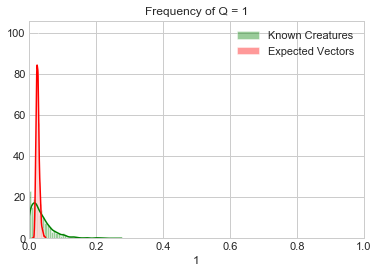

In [17]:
plot_qfreq(kc_qdf, ev_qdf, 1)

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

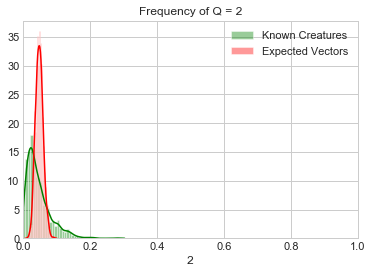

In [18]:
plot_qfreq(kc_qdf, ev_qdf, 2)

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

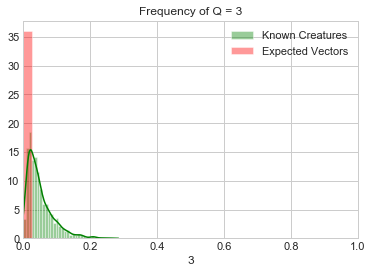

In [19]:
plot_qfreq(kc_qdf, ev_qdf, 3)

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

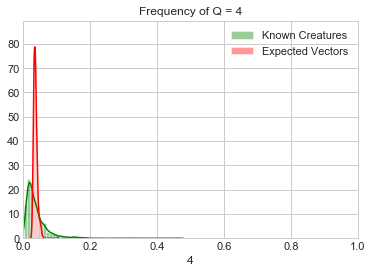

In [20]:
plot_qfreq(kc_qdf, ev_qdf, 4)

# Classification

Distinguish between known creatures (`True`) and expected vectors (`False`).

In [21]:
X = kc_qfreq + ev_qfreq
y = [True for i in kc_qfreq] + [False for i in ev_qfreq]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=820)

In [23]:
clf = LogisticRegression(
    random_state=0, solver="liblinear", multi_class="ovr", max_iter=200
).fit(X_train, y_train)
print("Mean Train Accuracy = {0:.3f}".format(clf.score(X_train, y_train)))
print("Mean Test Accuracy = {0:.3f}".format(clf.score(X_test, y_test)))
print(clf.classes_)
w = clf.coef_[0]
w

Mean Train Accuracy = 0.826
Mean Test Accuracy = 0.820
[False  True]


array([-5.37720197,  2.15129582, -2.7828926 , 12.3475064 , -1.90558047])

The class distribution is 50/50 between known creatures/expected vectors. Accuracy seems fine, more important to consider the full confusion matrix

The weight values of the regression model make sense given the above histograms:
- Note that all weight values were normalized into the range [0, 1]
- `w0` is negative, influences prediction towards EV
- `w3` has the greatest absolute value and influences prediction towards KC
- It is not clear how signicant `w1`, `w2`, and `w4` are.

In [29]:
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TP = {}\tFN = {}".format(tp, fn))
print("FP = {}\t\tTN = {}".format(fp, tn))

TP = 301	FN = 156
FP = 0		TN = 409


The confusion matrix shows no false positives, meaning that the model did not predict any expected vectors as creatures. This is upsetting, we had hoped to find some creature-like expected vectors from the classification errors.

The false negative cases, known creatures classified as not creature-like, account for all of the test classification inaccuracies.

For now, we are satisfied with the accuracy level because the classifier did not misclassify any expected vectors. However, we cannot rule out overfitting because we cannot be sure that the expected vectors are representative of reasonable creature candidates. We also cannot be sure that there truly are no creature-like expected vectors in the test dataset.

We will look for low values of `P(False|x)` to identify possible creature-like expected vectors.

In [46]:
ev_proba_t = clf.predict_proba(ev_qfreq)[:,1]
len(ev_proba_t)

1298

In [49]:
ev_qdf["pt"] = ev_proba_t
ev_qdf.sort_values(by="pt", ascending=False).head(5)

,0,1,2,3,4,pt
507,0.781141,0.046766,0.067925,0.0,0.104167,0.486467
665,0.815104,0.047309,0.078993,0.0,0.058594,0.455230
470,0.830621,0.045681,0.067925,0.0,0.055773,0.442673
1269,0.832465,0.046984,0.067057,0.0,0.053494,0.442584
1039,0.823242,0.042209,0.089627,0.0,0.044922,0.440821


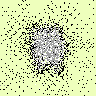

In [52]:
ph.showim(expected_vectors[507])

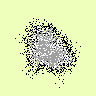

In [53]:
ph.showim(expected_vectors[665])

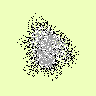

In [54]:
ph.showim(expected_vectors[470])

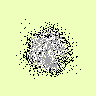

In [55]:
ph.showim(expected_vectors[1269])

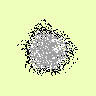

In [56]:
ph.showim(expected_vectors[1039])

The top five true negative cases look somewhat like the silhouettes of creatures. Perhaps these would be suitable starting points for a search algorithm.